In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

df = pd.read_csv("shopping_trends.csv")

customer_df = df.groupby("Customer ID").agg({
    "Purchase Amount (USD)": ["sum", "mean"],
    "Frequency of Purchases": "sum",
    "Discount Applied": "sum",
    "Promo Code Used": "sum"
})

customer_df.columns = ['_'.join(col) for col in customer_df.columns]

customer_df["Segment"] = pd.qcut(
    customer_df["Purchase Amount (USD)_sum"],
    q=3,
    labels=["Low", "Medium", "High"]
)

customer_df.head()

,Purchase Amount (USD)_sum,Purchase Amount (USD)_mean,Frequency of Purchases_sum,Discount Applied_sum,Promo Code Used_sum,Segment
Customer ID,,,,,,
1,53,53.0,Fortnightly,Yes,Yes,Medium
2,64,64.0,Fortnightly,Yes,Yes,Medium
3,73,73.0,Weekly,Yes,Yes,Medium
4,90,90.0,Weekly,Yes,Yes,High
5,49,49.0,Annually,Yes,Yes,Medium


In [7]:
customer_df["Promo Code Used_sum"] = customer_df["Promo Code Used_sum"].replace({
    "Yes": 1,
    "No": 0
}).astype(int)

customer_df["Discount Applied_sum"] = customer_df["Discount Applied_sum"].replace({
    "Yes": 1,
    "No": 0
}).astype(int)

/var/folders/_g/5gsytcbn7hjdc6r2knxpll480000gn/T/ipykernel_38005/4031835087.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_df["Promo Code Used_sum"] = customer_df["Promo Code Used_sum"].replace({
/var/folders/_g/5gsytcbn7hjdc6r2knxpll480000gn/T/ipykernel_38005/4031835087.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_df["Discount Applied_sum"] = customer_df["Discount Applied_sum"].replace({


In [8]:
customer_df["Used_Promo"] = (customer_df["Promo Code Used_sum"] > 0).astype(int)

In [9]:
customer_df[["Promo Code Used_sum", "Used_Promo"]].head()

,Promo Code Used_sum,Used_Promo
Customer ID,,
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

customer_df["Used_Promo"] = (customer_df["Promo Code Used_sum"] > 0).astype(int)

X = customer_df.drop(["Used_Promo", "Segment"], axis=1)
y = customer_df["Used_Promo"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

y_prob = gb.predict_proba(X_test)[:,1]
y_pred = gb.predict(X_test)

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ValueError: could not convert string to float: 'Weekly'

In [12]:
X.dtypes


Purchase Amount (USD)_sum       int64
Purchase Amount (USD)_mean    float64
Frequency of Purchases_sum     object
Discount Applied_sum            int64
Promo Code Used_sum             int64
dtype: object

In [13]:
# Convert all object (text) columns into numeric codes
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].astype("category").cat.codes

In [17]:
import shap
print(shap.__version__)

0.50.0


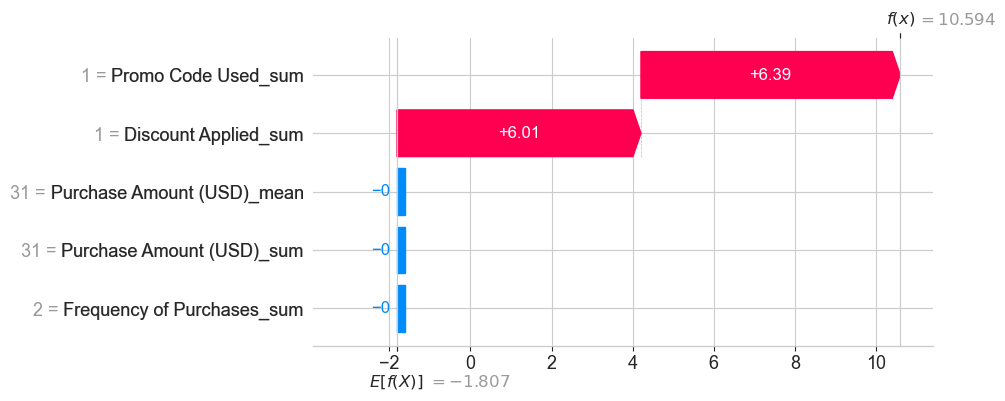

In [23]:
# Get the SHAP Explanation object for the first test sample
shap_exp = explainer(X_test.iloc[[0]])
shap.plots.waterfall(shap_exp[0])

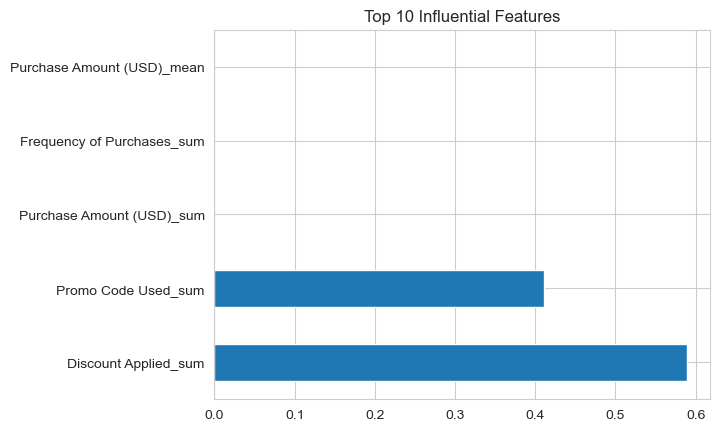

In [25]:
importances = pd.Series(
    gb.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances.head(10).plot(kind="barh")
plt.title("Top 10 Influential Features")
plt.show()

In [27]:
def explain_customer(idx):
    row = shap_values[idx]
    top = sorted(
        zip(X_train.columns, row),
        key=lambda x: abs(x[1]),
        reverse=True
    )[:3]

    text = "Offer recommended because: "
    for f, val in top:
        text += f"{f}, "
    return text

print(explain_customer(0))

Offer recommended because: Promo Code Used_sum, Discount Applied_sum, Purchase Amount (USD)_mean, 


In [29]:
customer_df["Predicted_Promo_Prob"] = gb.predict_proba(X)[:,1]

In [30]:
customer_df.sort_values("Predicted_Promo_Prob", ascending=False).head(10)

,Purchase Amount (USD)_sum,Purchase Amount (USD)_mean,Frequency of Purchases_sum,Discount Applied_sum,Promo Code Used_sum,Segment,Used_Promo,Predicted_Promo_Prob
Customer ID,,,,,,,,
1,53,53.0,Fortnightly,1,1,Medium,1,0.999975
1154,41,41.0,Quarterly,1,1,Low,1,0.999975
1126,90,90.0,Weekly,1,1,High,1,0.999975
1125,20,20.0,Quarterly,1,1,Low,1,0.999975
1124,67,67.0,Monthly,1,1,Medium,1,0.999975
1123,62,62.0,Annually,1,1,Medium,1,0.999975
1122,58,58.0,Quarterly,1,1,Medium,1,0.999975
1121,84,84.0,Monthly,1,1,High,1,0.999975
1120,36,36.0,Weekly,1,1,Low,1,0.999975


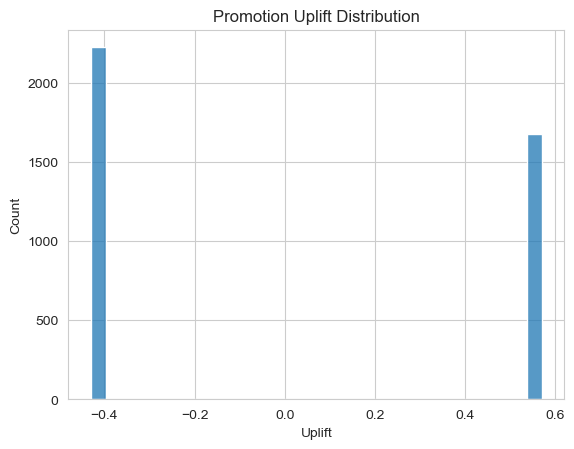

In [31]:
baseline = customer_df["Used_Promo"].mean()
customer_df["Uplift"] = customer_df["Predicted_Promo_Prob"] - baseline

sns.histplot(customer_df["Uplift"], bins=30)
plt.title("Promotion Uplift Distribution")
plt.show()

/var/folders/_g/5gsytcbn7hjdc6r2knxpll480000gn/T/ipykernel_38005/978093237.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  customer_df.groupby("Segment")["Uplift"].mean().plot(kind="bar")


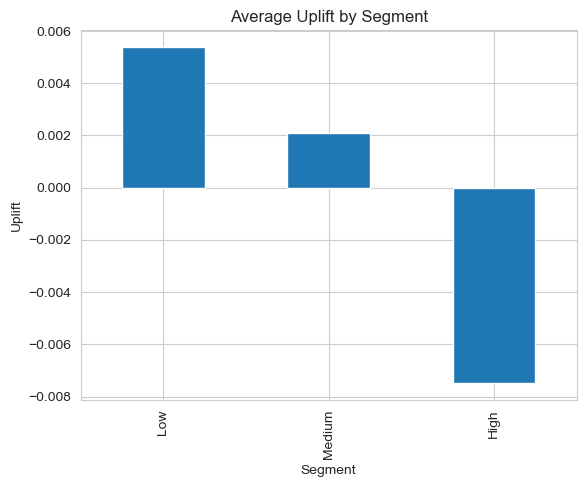

In [32]:
customer_df.groupby("Segment")["Uplift"].mean().plot(kind="bar")
plt.title("Average Uplift by Segment")
plt.ylabel("Uplift")
plt.show()

In [19]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# -------------------------------
# Step 0: Start from your main customer dataset
# Replace this with your actual dataset if available
# Example: 100 sample customers with Recency, Frequency, Monetary
num_customers = 100
df = pd.DataFrame({
    'Customer_ID': range(1, num_customers+1),
    'Recency': np.random.randint(1, 100, num_customers),
    'Frequency': np.random.randint(1, 50, num_customers),
    'Monetary': np.random.randint(100, 1000, num_customers)
})

# -------------------------------
# Step 1: Simulate Offer Probability and Uplift
# -------------------------------
df['Offer_Probability'] = np.random.rand(num_customers)  # random scores between 0-1
df['Uplift'] = df['Offer_Probability'] - 0.5  # simple uplift relative to baseline

# -------------------------------
# Step 2: Create customer segments
# -------------------------------
seg_features = ['Recency', 'Frequency', 'Monetary']
kmeans = KMeans(n_clusters=3, random_state=42)
df['Segment'] = kmeans.fit_predict(df[seg_features])

# -------------------------------
# Step 3: Add dummy top features for explainability
# -------------------------------
df['Top_3_Features'] = 'Recency, Frequency, Monetary'
df['Top_3_SHAP_Values'] = '0.20, 0.15, 0.10'

# -------------------------------
# Step 4: Export to CSV for Power BI
# -------------------------------
df.to_csv("personalized_offers_for_powerbi.csv", index=False)
print("✅ Exported personalized_offers_for_powerbi.csv successfully!")
print(df.head())

✅ Exported personalized_offers_for_powerbi.csv successfully!
   Customer_ID  Recency  Frequency  Monetary  Offer_Probability    Uplift  \
0            1       38         29       680           0.748771  0.248771   
1            2       18         29       238           0.830704  0.330704   
2            3       85          2       722           0.074077 -0.425923   
3            4       75         13       727           0.247548 -0.252452   
4            5       50         14       681           0.249884 -0.250116   

   Segment                Top_3_Features Top_3_SHAP_Values  
0        2  Recency, Frequency, Monetary  0.20, 0.15, 0.10  
1        0  Recency, Frequency, Monetary  0.20, 0.15, 0.10  
2        1  Recency, Frequency, Monetary  0.20, 0.15, 0.10  
3        1  Recency, Frequency, Monetary  0.20, 0.15, 0.10  
4        2  Recency, Frequency, Monetary  0.20, 0.15, 0.10  
